# Bar Type EDA: Volume vs Dollar Bars

Exploratory data analysis on cleaned data to determine whether to use **volume bars** or **dollar bars** for feature engineering.

3 liquid stocks (with 2 days of data) are analyzed to measure:

1. **Uniformity of flow** - Coefficient of Variation (CV) of per-second aggregates
2. **Burstiness** - Fano factor (variance/mean) of flow
3. **Intraday profiles** - Stability across trading hours
4. **Zero-activity periods** - Frequency of empty seconds
5. **Prototype bar properties** - Inter-bar duration stability and return whiteness

**Goal**: Choose the bar type that produces more stationary, i.i.d.-like returns.


In [1]:
import os
import sys

os.chdir('..')
print(f"Working directory: {os.getcwd()}")

Working directory: c:\Users\doqui\OneDrive\Documents\cs4641-131-project


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from scipy import stats
import warnings
warnings.filterwarnings('ignore')

# Set style
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (14, 8)
plt.rcParams['font.size'] = 10

print("Libraries imported successfully!")


Libraries imported successfully!


## 1. Data Loading

In [3]:
# Load metadata to identify liquid tickers
metadata = pd.read_csv('data/clean/metadata.csv')
print(f"Total files: {len(metadata)}")
print(f"\nTickers available: {sorted(metadata['ticker'].unique())}")

# Select 3 liquid tickers based on trade count
ticker_stats = metadata.groupby('ticker')['final_rows'].agg(['mean', 'sum']).sort_values('mean', ascending=False)
print("\nTicker statistics (by avg daily trades):")
print(ticker_stats.head(10))

# Select top 3 liquid tickers
sample_tickers = ticker_stats.head(3).index.tolist()
print(f"\nSelected tickers for analysis: {sample_tickers}")


Total files: 100

Tickers available: ['CCL', 'CNC', 'DAL', 'DECK', 'DLTR', 'DOW', 'DXCM', 'EQT', 'FCX', 'INTC', 'KVUE', 'MCHP', 'NCLH', 'ON', 'PCG', 'SLB', 'SMCI', 'TTD', 'UBER', 'XYZ']

Ticker statistics (by avg daily trades):
           mean     sum
ticker                 
INTC    46246.8  231234
SMCI    21622.2  108111
FCX     17694.2   88471
PCG     16711.2   83556
KVUE    15024.6   75123
CCL     13058.0   65290
TTD     10830.4   54152
UBER    10393.6   51968
CNC      9897.8   49489
DOW      9248.4   46242

Selected tickers for analysis: ['INTC', 'SMCI', 'FCX']


In [4]:
# Select 2 days for each ticker
sample_dates = ['10-2-25', '10-3-25']

# Load data
data_dict = {}
for ticker in sample_tickers:
    data_dict[ticker] = {}
    for date in sample_dates:
        file_path = f'data/clean/{ticker}/{ticker}_{date}_clean.parquet'
        if Path(file_path).exists():
            df = pd.read_parquet(file_path)
            # Filter only trades
            df = df[df['type'] == 'TRADE'].copy()
            data_dict[ticker][date] = df
            print(f"Loaded {ticker} {date}: {len(df):,} trades")
        else:
            print(f"File not found: {file_path}")

print(f"\nTotal datasets loaded: {sum(len(v) for v in data_dict.values())}")


Loaded INTC 10-2-25: 56,511 trades
Loaded INTC 10-3-25: 43,633 trades
Loaded SMCI 10-2-25: 19,518 trades
Loaded SMCI 10-3-25: 19,283 trades
Loaded FCX 10-2-25: 18,967 trades
Loaded FCX 10-3-25: 15,634 trades

Total datasets loaded: 6


## 2. Per-Second Flow Analysis

Aggregate volume and dollar value per second to measure uniformity and burstiness.


In [6]:
def compute_per_second_stats(df):
    """
    Compute per-second volume and dollar flow statistics.
    
    Returns:
        dict with volume and dollar flow metrics
    """
    # Create a copy and compute dollar value
    df = df.copy()
    df['dollar_value'] = df['price'] * df['size']
    
    # Resample to 1-second bins
    df.set_index('ts', inplace=True)
    
    # Aggregate per second
    per_sec = df.resample('1S').agg({
        'size': 'sum',           # volume
        'dollar_value': 'sum',   # dollar value
        'price': 'count'         # trade count
    }).rename(columns={'price': 'trade_count'})
    
    per_sec = per_sec.between_time('13:35', '19:35')
    
        # Compute statistics
    flow_stats = {
        'volume_mean': per_sec['size'].mean(),
        'volume_std': per_sec['size'].std(),
        'volume_cv': per_sec['size'].std() / per_sec['size'].mean() if per_sec['size'].mean() > 0 else np.nan,
        'volume_fano': per_sec['size'].var() / per_sec['size'].mean() if per_sec['size'].mean() > 0 else np.nan,
        'volume_zeros': (per_sec['size'] == 0).sum(),
        'volume_zeros_pct': (per_sec['size'] == 0).mean() * 100,

        'dollar_mean': per_sec['dollar_value'].mean(),
        'dollar_std': per_sec['dollar_value'].std(),
        'dollar_cv': per_sec['dollar_value'].std() / per_sec['dollar_value'].mean() if per_sec['dollar_value'].mean() > 0 else np.nan,
        'dollar_fano': per_sec['dollar_value'].var() / per_sec['dollar_value'].mean() if per_sec['dollar_value'].mean() > 0 else np.nan,
        'dollar_zeros': (per_sec['dollar_value'] == 0).sum(),
        'dollar_zeros_pct': (per_sec['dollar_value'] == 0).mean() * 100,

        'total_seconds': len(per_sec),
        'total_trades': per_sec['trade_count'].sum(),
    }

    return flow_stats, per_sec

# Compute stats for all datasets
all_stats = []
all_per_sec = {}

for ticker in data_dict:
    for date in data_dict[ticker]:
        df = data_dict[ticker][date]
        flow_stats, per_sec = compute_per_second_stats(df)
        flow_stats['ticker'] = ticker
        flow_stats['date'] = date
        all_stats.append(flow_stats)
        all_per_sec[f"{ticker}_{date}"] = per_sec

stats_df = pd.DataFrame(all_stats)
print("Per-second flow statistics computed!")
print(f"\nShape: {stats_df.shape}")
stats_df


Per-second flow statistics computed!

Shape: (6, 16)


,volume_mean,volume_std,volume_cv,volume_fano,volume_zeros,volume_zeros_pct,dollar_mean,dollar_std,dollar_cv,dollar_fano,dollar_zeros,dollar_zeros_pct,total_seconds,total_trades,ticker,date
0,827.295926,2980.110552,3.602230,10735.044893,11778,54.527778,30324.738909,109298.111946,3.604256,393938.338952,11778,54.527778,21600,56511,INTC,10-2-25
1,537.218426,2081.241957,3.874108,8062.955168,13154,60.898148,20022.888747,77551.916091,3.873163,300371.228412,13154,60.898148,21600,43633,INTC,10-3-25
2,150.842785,575.938683,3.818139,2199.013801,15368,71.144854,7843.417138,29942.996874,3.817596,114310.261216,15368,71.144854,21601,19518,SMCI,10-2-25
3,156.452310,654.914378,4.186032,2741.492548,15003,69.464765,8162.434801,34217.788260,4.192106,143444.580197,15003,69.464765,21598,19283,SMCI,10-3-25
4,150.494884,831.350944,5.524114,4592.477658,16017,74.156211,5820.007325,32098.797816,5.515250,177032.907975,16017,74.156211,21599,18967,FCX,10-2-25
5,112.448231,487.825778,4.338225,2116.298202,16773,77.667161,4470.686056,19367.513080,4.332112,83902.237415,16773,77.667161,21596,15634,FCX,10-3-25


COEFFICIENT OF VARIATION (CV) - Lower = better
Volume CV:  Mean = 4.2238, Std = 0.6897
Dollar CV:  Mean = 4.2224, Std = 0.6859
Winner: DOLLAR bars

FANO FACTOR (Variance/Mean) - Lower = better
Volume Fano:  Mean = 5074.5470, Std = 3568.3969
Dollar Fano:  Mean = 202166.5924, Std = 120171.3133
Winner: VOLUME bars

ZERO-ACTIVITY PERIODS (%) - Lower = better
Volume zeros:  Mean = 67.98%, Std = 8.66%
Dollar zeros:  Mean = 67.98%, Std = 8.66%
Winner: VOLUME bars


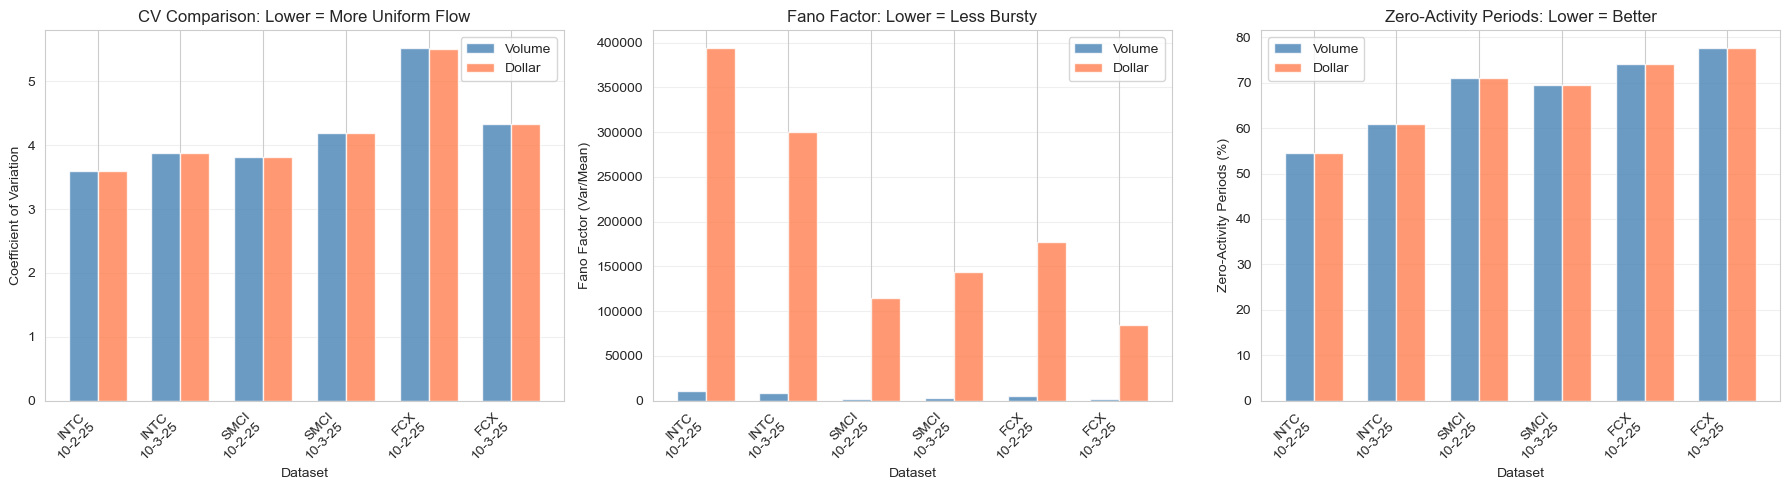

In [7]:
# Summary statistics
print("="*80)
print("COEFFICIENT OF VARIATION (CV) - Lower = better")
print("="*80)
print(f"Volume CV:  Mean = {stats_df['volume_cv'].mean():.4f}, Std = {stats_df['volume_cv'].std():.4f}")
print(f"Dollar CV:  Mean = {stats_df['dollar_cv'].mean():.4f}, Std = {stats_df['dollar_cv'].std():.4f}")
print(f"Winner: {'DOLLAR' if stats_df['dollar_cv'].mean() < stats_df['volume_cv'].mean() else 'VOLUME'} bars")

print("\n" + "="*80)
print("FANO FACTOR (Variance/Mean) - Lower = better")
print("="*80)
print(f"Volume Fano:  Mean = {stats_df['volume_fano'].mean():.4f}, Std = {stats_df['volume_fano'].std():.4f}")
print(f"Dollar Fano:  Mean = {stats_df['dollar_fano'].mean():.4f}, Std = {stats_df['dollar_fano'].std():.4f}")
print(f"Winner: {'DOLLAR' if stats_df['dollar_fano'].mean() < stats_df['volume_fano'].mean() else 'VOLUME'} bars")

print("\n" + "="*80)
print("ZERO-ACTIVITY PERIODS (%) - Lower = better")
print("="*80)
print(f"Volume zeros:  Mean = {stats_df['volume_zeros_pct'].mean():.2f}%, Std = {stats_df['volume_zeros_pct'].std():.2f}%")
print(f"Dollar zeros:  Mean = {stats_df['dollar_zeros_pct'].mean():.2f}%, Std = {stats_df['dollar_zeros_pct'].std():.2f}%")
print(f"Winner: {'DOLLAR' if stats_df['dollar_zeros_pct'].mean() < stats_df['volume_zeros_pct'].mean() else 'VOLUME'} bars")

# Visualize
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# CV comparison
ax = axes[0]
x = np.arange(len(stats_df))
width = 0.35
ax.bar(x - width/2, stats_df['volume_cv'], width, label='Volume', alpha=0.8, color='steelblue')
ax.bar(x + width/2, stats_df['dollar_cv'], width, label='Dollar', alpha=0.8, color='coral')
ax.set_xlabel('Dataset')
ax.set_ylabel('Coefficient of Variation')
ax.set_title('CV Comparison: Lower = More Uniform Flow')
ax.set_xticks(x)
ax.set_xticklabels([f"{row['ticker']}\n{row['date']}" for _, row in stats_df.iterrows()], rotation=45, ha='right')
ax.legend()
ax.grid(axis='y', alpha=0.3)

# Fano factor comparison
ax = axes[1]
ax.bar(x - width/2, stats_df['volume_fano'], width, label='Volume', alpha=0.8, color='steelblue')
ax.bar(x + width/2, stats_df['dollar_fano'], width, label='Dollar', alpha=0.8, color='coral')
ax.set_xlabel('Dataset')
ax.set_ylabel('Fano Factor (Var/Mean)')
ax.set_title('Fano Factor: Lower = Less Bursty')
ax.set_xticks(x)
ax.set_xticklabels([f"{row['ticker']}\n{row['date']}" for _, row in stats_df.iterrows()], rotation=45, ha='right')
ax.legend()
ax.grid(axis='y', alpha=0.3)

# Zero periods comparison
ax = axes[2]
ax.bar(x - width/2, stats_df['volume_zeros_pct'], width, label='Volume', alpha=0.8, color='steelblue')
ax.bar(x + width/2, stats_df['dollar_zeros_pct'], width, label='Dollar', alpha=0.8, color='coral')
ax.set_xlabel('Dataset')
ax.set_ylabel('Zero-Activity Periods (%)')
ax.set_title('Zero-Activity Periods: Lower = Better')
ax.set_xticks(x)
ax.set_xticklabels([f"{row['ticker']}\n{row['date']}" for _, row in stats_df.iterrows()], rotation=45, ha='right')
ax.legend()
ax.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()


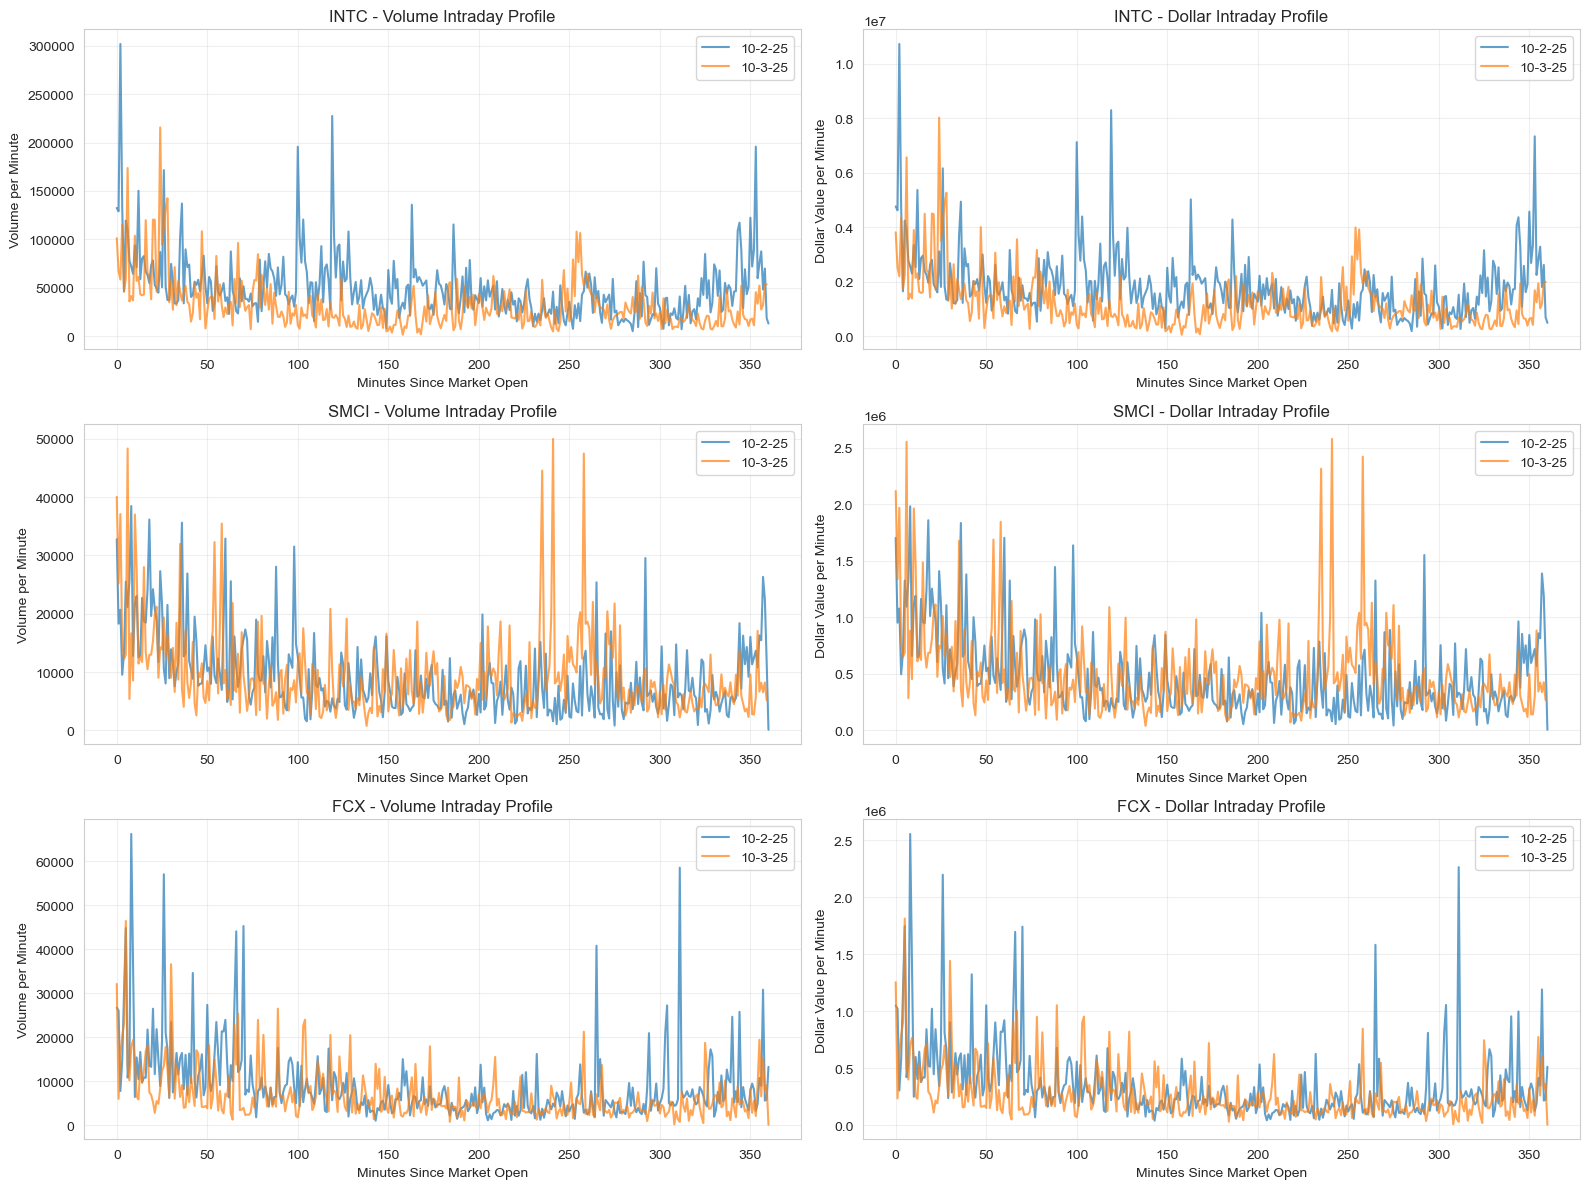


INTRADAY PROFILE STABILITY (CV across minutes)
INTC:
  Volume CV: 0.5636
  Dollar CV: 0.5583
  Winner: DOLLAR

SMCI:
  Volume CV: 0.5992
  Dollar CV: 0.5998
  Winner: VOLUME

FCX:
  Volume CV: 0.7435
  Dollar CV: 0.7385
  Winner: DOLLAR



In [8]:
# Analyze intraday profiles
def compute_intraday_profile(per_sec_dict):
    """
    Compute average flow per minute across the trading day.
    """
    profiles = []
    
    for key, per_sec in per_sec_dict.items():
        ticker, date = key.split('_')
        
        # Resample to per-minute
        per_min = per_sec.resample('1T').agg({
            'size': 'sum',
            'dollar_value': 'sum'
        })
        
        # Add time of day (minutes since market open)
        per_min['minute_of_day'] = (per_min.index.hour - 13) * 60 + per_min.index.minute
        # Adjust for market open at 13:30 UTC (9:30 ET)
        per_min['minute_of_day'] = per_min['minute_of_day'] - 30
        
        # Filter to valid hours
        per_min = per_min.between_time("13:35", "19:35")

        # Minutes since 13:35 UTC
        tod = per_min.index - per_min.index.normalize()
        per_min["minute_of_day"] = (
            (tod / pd.Timedelta(minutes=1)) - (13 * 60 + 35)
        ).astype(int)
        per_min["ticker"] = ticker
        per_min["date"] = date
        profiles.append(per_min)
    
    return pd.concat(profiles)

intraday_df = compute_intraday_profile(all_per_sec)

# Plot intraday profiles
fig, axes = plt.subplots(len(sample_tickers), 2, figsize=(16, 4*len(sample_tickers)))

for i, ticker in enumerate(sample_tickers):
    ticker_data = intraday_df[intraday_df['ticker'] == ticker]
    
    # Volume profile
    ax = axes[i, 0] if len(sample_tickers) > 1 else axes[0]
    for date in sample_dates:
        date_data = ticker_data[ticker_data['date'] == date]
        if len(date_data) > 0:
            ax.plot(date_data['minute_of_day'], date_data['size'], 
                   label=date, alpha=0.7, linewidth=1.5)
    ax.set_xlabel('Minutes Since Market Open')
    ax.set_ylabel('Volume per Minute')
    ax.set_title(f'{ticker} - Volume Intraday Profile')
    ax.legend()
    ax.grid(alpha=0.3)
    
    # Dollar profile
    ax = axes[i, 1] if len(sample_tickers) > 1 else axes[1]
    for date in sample_dates:
        date_data = ticker_data[ticker_data['date'] == date]
        if len(date_data) > 0:
            ax.plot(date_data['minute_of_day'], date_data['dollar_value'], 
                   label=date, alpha=0.7, linewidth=1.5)
    ax.set_xlabel('Minutes Since Market Open')
    ax.set_ylabel('Dollar Value per Minute')
    ax.set_title(f'{ticker} - Dollar Intraday Profile')
    ax.legend()
    ax.grid(alpha=0.3)

plt.tight_layout()
plt.show()

# Compute CV of intraday profiles
print("\n" + "="*80)
print("INTRADAY PROFILE STABILITY (CV across minutes)")
print("="*80)
for ticker in sample_tickers:
    ticker_data = intraday_df[intraday_df['ticker'] == ticker]
    
    # Average across days
    avg_profile = ticker_data.groupby('minute_of_day').agg({
        'size': 'mean',
        'dollar_value': 'mean'
    })
    
    vol_cv = avg_profile['size'].std() / avg_profile['size'].mean()
    dollar_cv = avg_profile['dollar_value'].std() / avg_profile['dollar_value'].mean()
    
    print(f"{ticker}:")
    print(f"  Volume CV: {vol_cv:.4f}")
    print(f"  Dollar CV: {dollar_cv:.4f}")
    print(f"  Winner: {'DOLLAR' if dollar_cv < vol_cv else 'VOLUME'}")
    print()


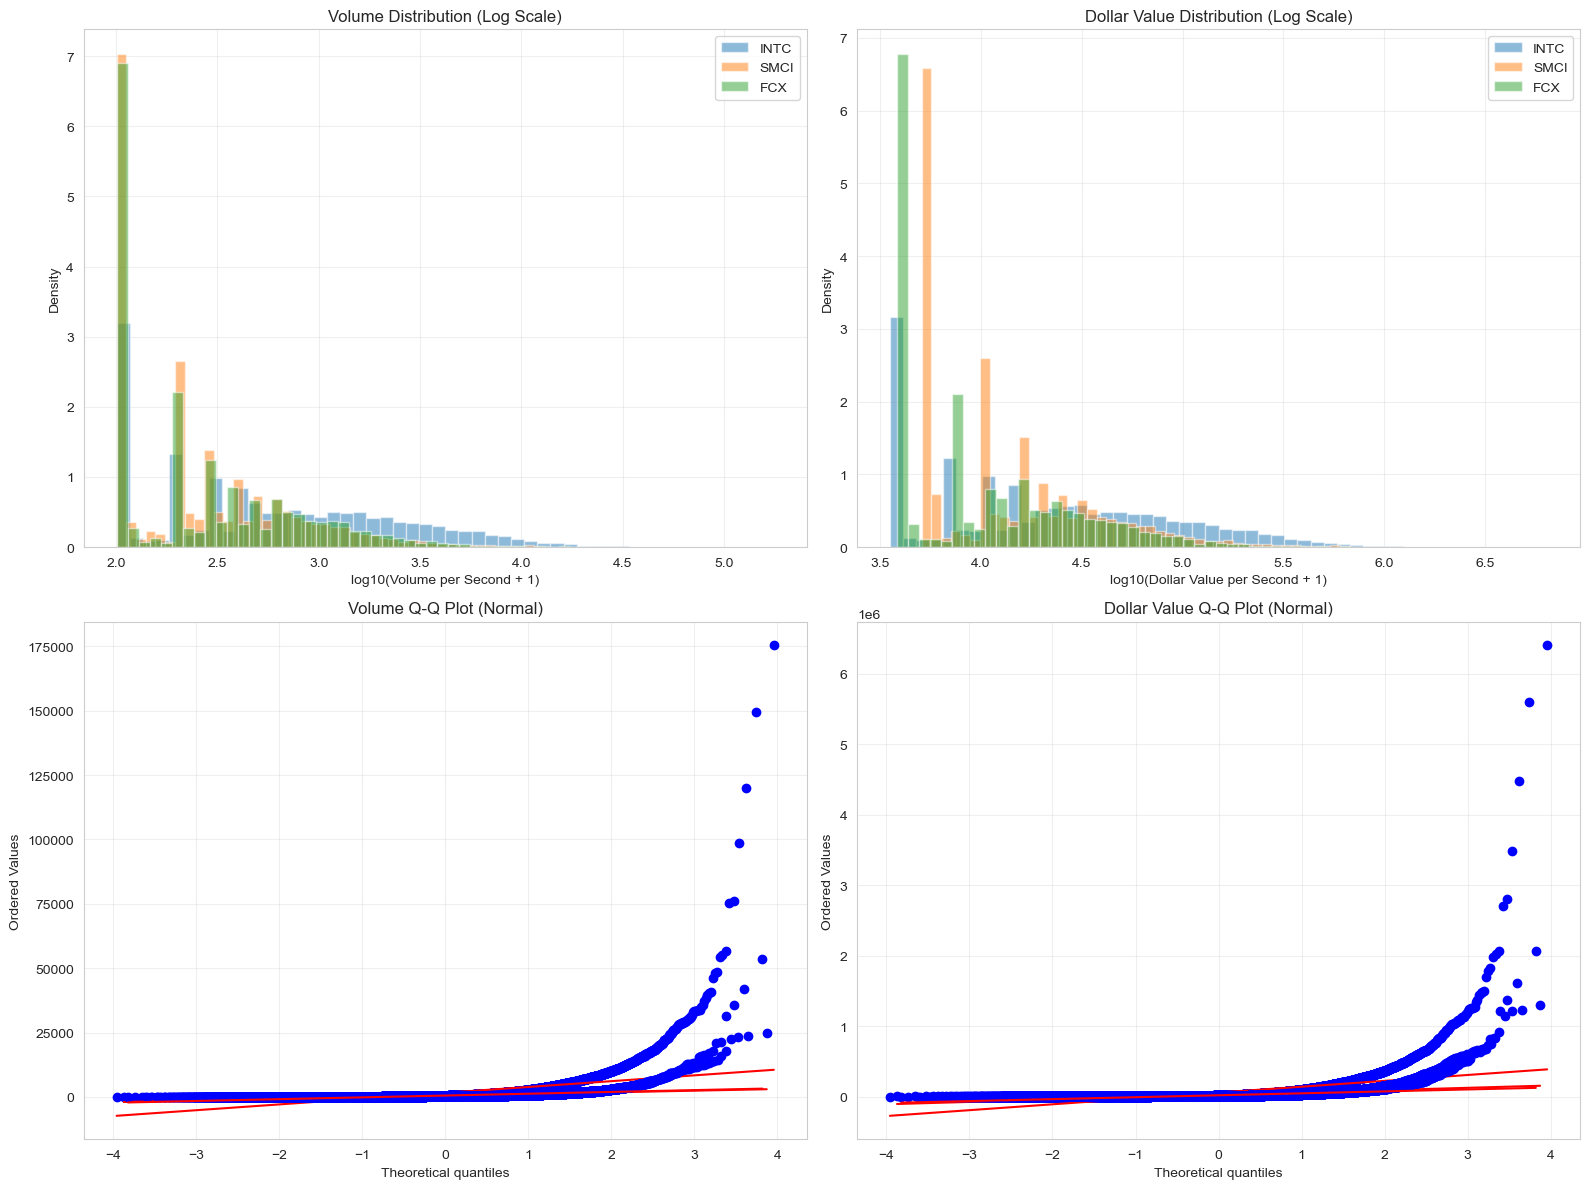


DISTRIBUTION STATISTICS (Skewness and Kurtosis)
Lower values indicate more normal-like distributions

INTC:
  Volume  - Skewness: 15.2513, Kurtosis: 494.5384
  Dollar  - Skewness: 15.2279, Kurtosis: 493.4976

SMCI:
  Volume  - Skewness: 8.6689, Kurtosis: 121.5789
  Dollar  - Skewness: 8.6634, Kurtosis: 121.1791

FCX:
  Volume  - Skewness: 16.4908, Kurtosis: 474.1319
  Dollar  - Skewness: 16.2195, Kurtosis: 460.3733



In [9]:
# Combine all per-second data for distribution analysis
all_per_sec_combined = []
for key, per_sec in all_per_sec.items():
    ticker, date = key.split('_')
    per_sec_copy = per_sec.copy()
    per_sec_copy['ticker'] = ticker
    per_sec_copy['date'] = date
    all_per_sec_combined.append(per_sec_copy)

combined_df = pd.concat(all_per_sec_combined)

# Plot distributions
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Volume distribution (log scale)
ax = axes[0, 0]
for ticker in sample_tickers:
    ticker_data = combined_df[combined_df['ticker'] == ticker]['size']
    ticker_data = ticker_data[ticker_data > 0]  # Remove zeros for log scale
    ax.hist(np.log10(ticker_data + 1), bins=50, alpha=0.5, label=ticker, density=True)
ax.set_xlabel('log10(Volume per Second + 1)')
ax.set_ylabel('Density')
ax.set_title('Volume Distribution (Log Scale)')
ax.legend()
ax.grid(alpha=0.3)

# Dollar distribution (log scale)
ax = axes[0, 1]
for ticker in sample_tickers:
    ticker_data = combined_df[combined_df['ticker'] == ticker]['dollar_value']
    ticker_data = ticker_data[ticker_data > 0]  # Remove zeros for log scale
    ax.hist(np.log10(ticker_data + 1), bins=50, alpha=0.5, label=ticker, density=True)
ax.set_xlabel('log10(Dollar Value per Second + 1)')
ax.set_ylabel('Density')
ax.set_title('Dollar Value Distribution (Log Scale)')
ax.legend()
ax.grid(alpha=0.3)

# Volume Q-Q plot
ax = axes[1, 0]
for ticker in sample_tickers:
    ticker_data = combined_df[combined_df['ticker'] == ticker]['size']
    ticker_data = ticker_data[ticker_data > 0]
    stats.probplot(ticker_data, dist="norm", plot=ax)
ax.set_title('Volume Q-Q Plot (Normal)')
ax.grid(alpha=0.3)

# Dollar Q-Q plot
ax = axes[1, 1]
for ticker in sample_tickers:
    ticker_data = combined_df[combined_df['ticker'] == ticker]['dollar_value']
    ticker_data = ticker_data[ticker_data > 0]
    stats.probplot(ticker_data, dist="norm", plot=ax)
ax.set_title('Dollar Value Q-Q Plot (Normal)')
ax.grid(alpha=0.3)

plt.tight_layout()
plt.show()

# Compute skewness and kurtosis
print("\n" + "="*80)
print("DISTRIBUTION STATISTICS (Skewness and Kurtosis)")
print("="*80)
print("Lower values indicate more normal-like distributions\n")

for ticker in sample_tickers:
    ticker_data = combined_df[combined_df['ticker'] == ticker]
    
    vol_data = ticker_data['size'][ticker_data['size'] > 0]
    dollar_data = ticker_data['dollar_value'][ticker_data['dollar_value'] > 0]
    
    print(f"{ticker}:")
    print(f"  Volume  - Skewness: {stats.skew(vol_data):.4f}, Kurtosis: {stats.kurtosis(vol_data):.4f}")
    print(f"  Dollar  - Skewness: {stats.skew(dollar_data):.4f}, Kurtosis: {stats.kurtosis(dollar_data):.4f}")
    print()


## 6. Prototype Bar Construction

Create sample bars using both methods and compare their properties.


In [10]:
def create_bars(df, bar_type='volume', threshold=None, target_bars_per_day=3000):
    """
    Create volume or dollar bars from tick data.
    
    Parameters:
    -----------
    df : pd.DataFrame
        Tick data with columns: ts, price, size
    bar_type : str
        'volume' or 'dollar'
    threshold : float
        Cumulative threshold for bar creation. If None, auto-compute based on target_bars_per_day
    target_bars_per_day : int
        Target number of bars per day (used if threshold is None)
    
    Returns:
    --------
    pd.DataFrame with bar data
    """
    df = df.copy()
    df['dollar_value'] = df['price'] * df['size']
    
    # Determine threshold if not provided
    if threshold is None:
        if bar_type == 'volume':
            total_volume = df['size'].sum()
        else:
            total_volume = df['dollar_value'].sum()
        threshold = total_volume / target_bars_per_day
    
    # Select cumulative column
    cum_col = 'size' if bar_type == 'volume' else 'dollar_value'
    
    # Create bars
    bars = []
    cum_sum = 0
    bar_trades = []
    
    for idx, row in df.iterrows():
        bar_trades.append(row)
        cum_sum += row[cum_col]
        
        if cum_sum >= threshold:
            # Create bar
            bar_df = pd.DataFrame(bar_trades)
            bar = {
                'ts_start': bar_df['ts'].iloc[0],
                'ts_end': bar_df['ts'].iloc[-1],
                'open': bar_df['price'].iloc[0],
                'high': bar_df['price'].max(),
                'low': bar_df['price'].min(),
                'close': bar_df['price'].iloc[-1],
                'volume': bar_df['size'].sum(),
                'dollar_value': bar_df['dollar_value'].sum(),
                'num_trades': len(bar_df),
                'vwap': (bar_df['price'] * bar_df['size']).sum() / bar_df['size'].sum()
            }
            bars.append(bar)
            
            # Reset for next bar
            bar_trades = []
            cum_sum = 0
    
    bars_df = pd.DataFrame(bars)
    if len(bars_df) > 0:
        bars_df['duration'] = (bars_df['ts_end'] - bars_df['ts_start']).dt.total_seconds()
        bars_df['return'] = np.log(bars_df['close'] / bars_df['open'])
    
    return bars_df, threshold

# Create bars for one ticker-date pair
test_ticker = sample_tickers[0]
test_date = sample_dates[0]
test_df = data_dict[test_ticker][test_date]

print(f"Creating prototype bars for {test_ticker} on {test_date}")
print(f"Total trades: {len(test_df):,}")

# Create volume bars
vol_bars, vol_threshold = create_bars(test_df, bar_type='volume', target_bars_per_day=3000)
print(f"\nVolume Bars:")
print(f"  Threshold: {vol_threshold:,.0f} shares")
print(f"  Bars created: {len(vol_bars):,}")
print(f"  Avg trades per bar: {vol_bars['num_trades'].mean():.1f}")

# Create dollar bars
dollar_bars, dollar_threshold = create_bars(test_df, bar_type='dollar', target_bars_per_day=3000)
print(f"\nDollar Bars:")
print(f"  Threshold: ${dollar_threshold:,.0f}")
print(f"  Bars created: {len(dollar_bars):,}")
print(f"  Avg trades per bar: {dollar_bars['num_trades'].mean():.1f}")

# Display sample bars
print("\n" + "="*80)
print("Sample Volume Bars:")
print(vol_bars.head())
print("\n" + "="*80)
print("Sample Dollar Bars:")
print(dollar_bars.head())


Creating prototype bars for INTC on 10-2-25
Total trades: 56,511

Volume Bars:
  Threshold: 5,957 shares
  Bars created: 2,698
  Avg trades per bar: 20.9

Dollar Bars:
  Threshold: $218,338
  Bars created: 2,700
  Avg trades per bar: 20.9

Sample Volume Bars:
                   ts_start                    ts_end       open       high  \
0 2025-10-02 13:35:01+00:00 2025-10-02 13:35:01+00:00  36.044998  36.084999   
1 2025-10-02 13:35:01+00:00 2025-10-02 13:35:07+00:00  36.080002  36.110001   
2 2025-10-02 13:35:07+00:00 2025-10-02 13:35:09+00:00  36.099998  36.110001   
3 2025-10-02 13:35:09+00:00 2025-10-02 13:35:09+00:00  36.044998  36.090000   
4 2025-10-02 13:35:09+00:00 2025-10-02 13:35:11+00:00  36.044998  36.090000   

         low      close  volume   dollar_value  num_trades       vwap  \
0  36.044998  36.080002    6419  231503.991661          31  36.065429   
1  36.049999  36.099998    6025  217402.163662          30  36.083347   
2  36.060001  36.080002    6212  224092.660187

## 7. Bar Duration Analysis

Compare inter-bar duration stability between volume and dollar bars.


BAR DURATION STATISTICS (seconds)

Volume Bars:
  Mean: 7.68s
  Std:  8.31s
  CV:   1.0821
  Min:  0.00s
  Max:  72.00s

Dollar Bars:
  Mean: 7.66s
  Std:  8.31s
  CV:   1.0840
  Min:  0.00s
  Max:  67.00s

Winner (lower CV): VOLUME bars


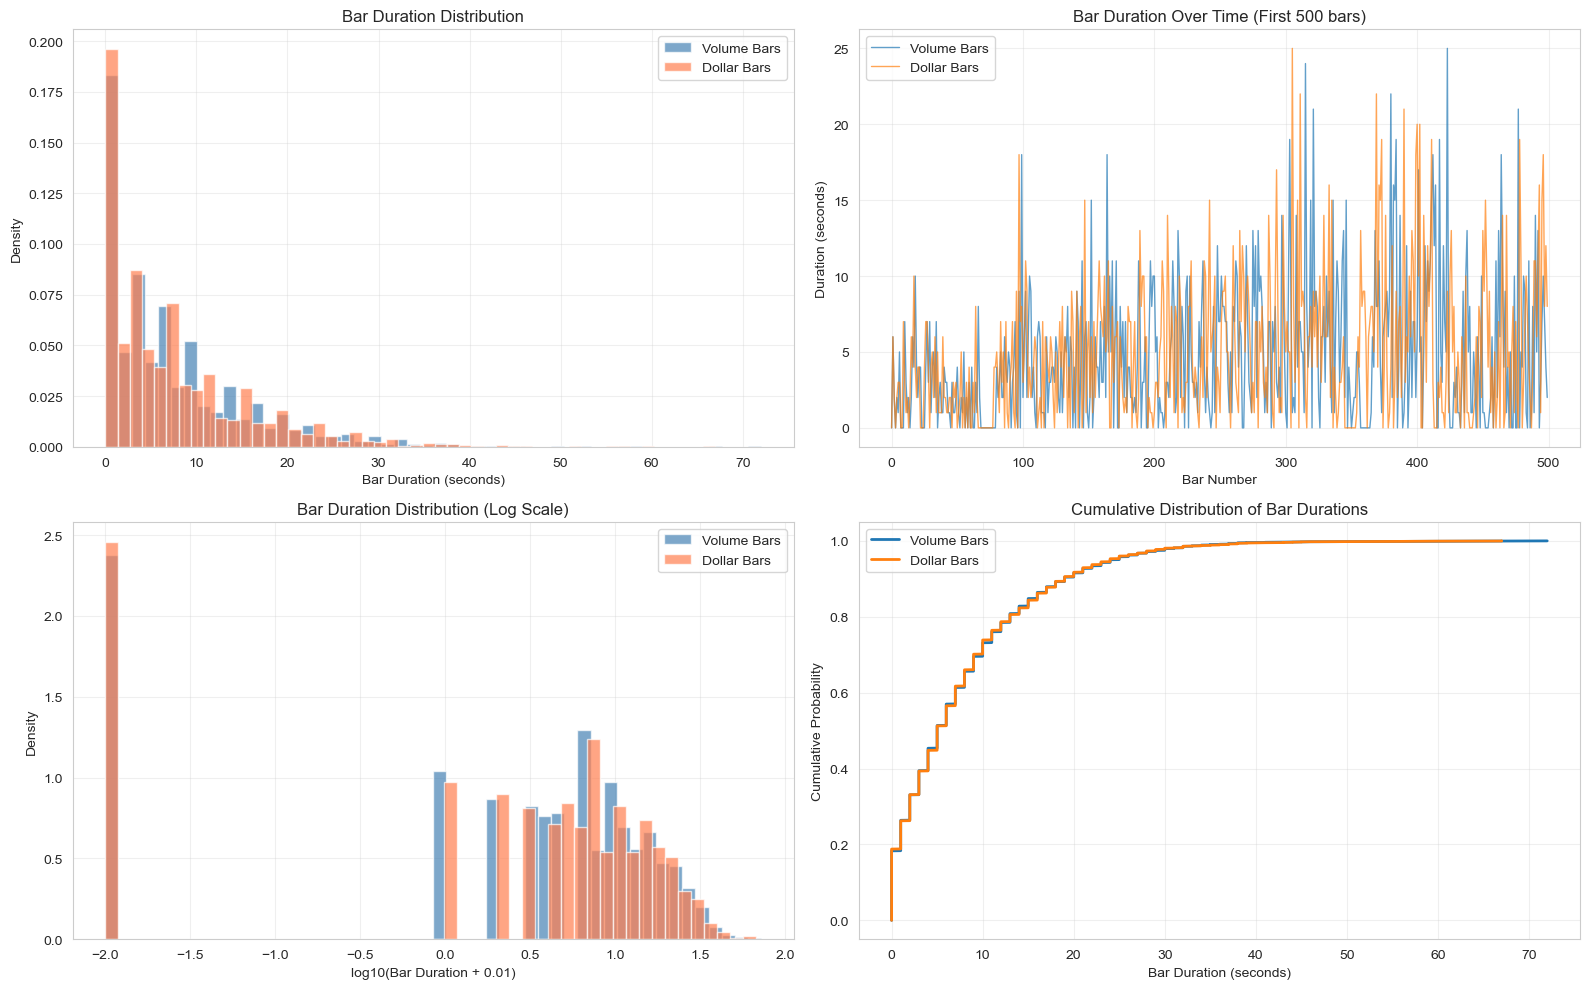

In [11]:
# Compare bar duration statistics
print("="*80)
print("BAR DURATION STATISTICS (seconds)")
print("="*80)

print("\nVolume Bars:")
print(f"  Mean: {vol_bars['duration'].mean():.2f}s")
print(f"  Std:  {vol_bars['duration'].std():.2f}s")
print(f"  CV:   {vol_bars['duration'].std() / vol_bars['duration'].mean():.4f}")
print(f"  Min:  {vol_bars['duration'].min():.2f}s")
print(f"  Max:  {vol_bars['duration'].max():.2f}s")

print("\nDollar Bars:")
print(f"  Mean: {dollar_bars['duration'].mean():.2f}s")
print(f"  Std:  {dollar_bars['duration'].std():.2f}s")
print(f"  CV:   {dollar_bars['duration'].std() / dollar_bars['duration'].mean():.4f}")
print(f"  Min:  {dollar_bars['duration'].min():.2f}s")
print(f"  Max:  {dollar_bars['duration'].max():.2f}s")

print(f"\nWinner (lower CV): {'DOLLAR' if (dollar_bars['duration'].std() / dollar_bars['duration'].mean()) < (vol_bars['duration'].std() / vol_bars['duration'].mean()) else 'VOLUME'} bars")

# Plot duration distributions
fig, axes = plt.subplots(2, 2, figsize=(16, 10))

# Duration histograms
ax = axes[0, 0]
ax.hist(vol_bars['duration'], bins=50, alpha=0.7, label='Volume Bars', color='steelblue', density=True)
ax.hist(dollar_bars['duration'], bins=50, alpha=0.7, label='Dollar Bars', color='coral', density=True)
ax.set_xlabel('Bar Duration (seconds)')
ax.set_ylabel('Density')
ax.set_title('Bar Duration Distribution')
ax.legend()
ax.grid(alpha=0.3)

# Duration time series
ax = axes[0, 1]
ax.plot(vol_bars.index[:500], vol_bars['duration'].iloc[:500], alpha=0.7, label='Volume Bars', linewidth=1)
ax.plot(dollar_bars.index[:500], dollar_bars['duration'].iloc[:500], alpha=0.7, label='Dollar Bars', linewidth=1)
ax.set_xlabel('Bar Number')
ax.set_ylabel('Duration (seconds)')
ax.set_title('Bar Duration Over Time (First 500 bars)')
ax.legend()
ax.grid(alpha=0.3)

# Log duration histograms
ax = axes[1, 0]
ax.hist(np.log10(vol_bars['duration'] + 0.01), bins=50, alpha=0.7, label='Volume Bars', color='steelblue', density=True)
ax.hist(np.log10(dollar_bars['duration'] + 0.01), bins=50, alpha=0.7, label='Dollar Bars', color='coral', density=True)
ax.set_xlabel('log10(Bar Duration + 0.01)')
ax.set_ylabel('Density')
ax.set_title('Bar Duration Distribution (Log Scale)')
ax.legend()
ax.grid(alpha=0.3)

# Cumulative distribution
ax = axes[1, 1]
vol_sorted = np.sort(vol_bars['duration'])
dollar_sorted = np.sort(dollar_bars['duration'])
ax.plot(vol_sorted, np.arange(len(vol_sorted)) / len(vol_sorted), label='Volume Bars', linewidth=2)
ax.plot(dollar_sorted, np.arange(len(dollar_sorted)) / len(dollar_sorted), label='Dollar Bars', linewidth=2)
ax.set_xlabel('Bar Duration (seconds)')
ax.set_ylabel('Cumulative Probability')
ax.set_title('Cumulative Distribution of Bar Durations')
ax.legend()
ax.grid(alpha=0.3)

plt.tight_layout()
plt.show()


## 8. Return Analysis

Examine return properties: autocorrelation, normality, and whiteness.


RETURN STATISTICS

Volume Bars:
  Mean:     0.000021
  Std:      0.000508
  Skewness: 0.1895
  Kurtosis: 2.4331

Dollar Bars:
  Mean:     0.000016
  Std:      0.000511
  Skewness: 0.1604
  Kurtosis: 2.6321

AUTOCORRELATION (Lag 1)
Volume Bars: 0.021621
Dollar Bars: 0.018348
Winner (closer to 0): DOLLAR bars

LJUNG-BOX TEST (H0: No autocorrelation)

Volume Bars:
  Test Statistic: 6.2398
  P-value:        0.794733
  Result:         Fail to reject H0 (no significant autocorrelation)

Dollar Bars:
  Test Statistic: 15.5146
  P-value:        0.114397
  Result:         Fail to reject H0 (no significant autocorrelation)

Winner (higher p-value = less autocorrelation): VOLUME bars


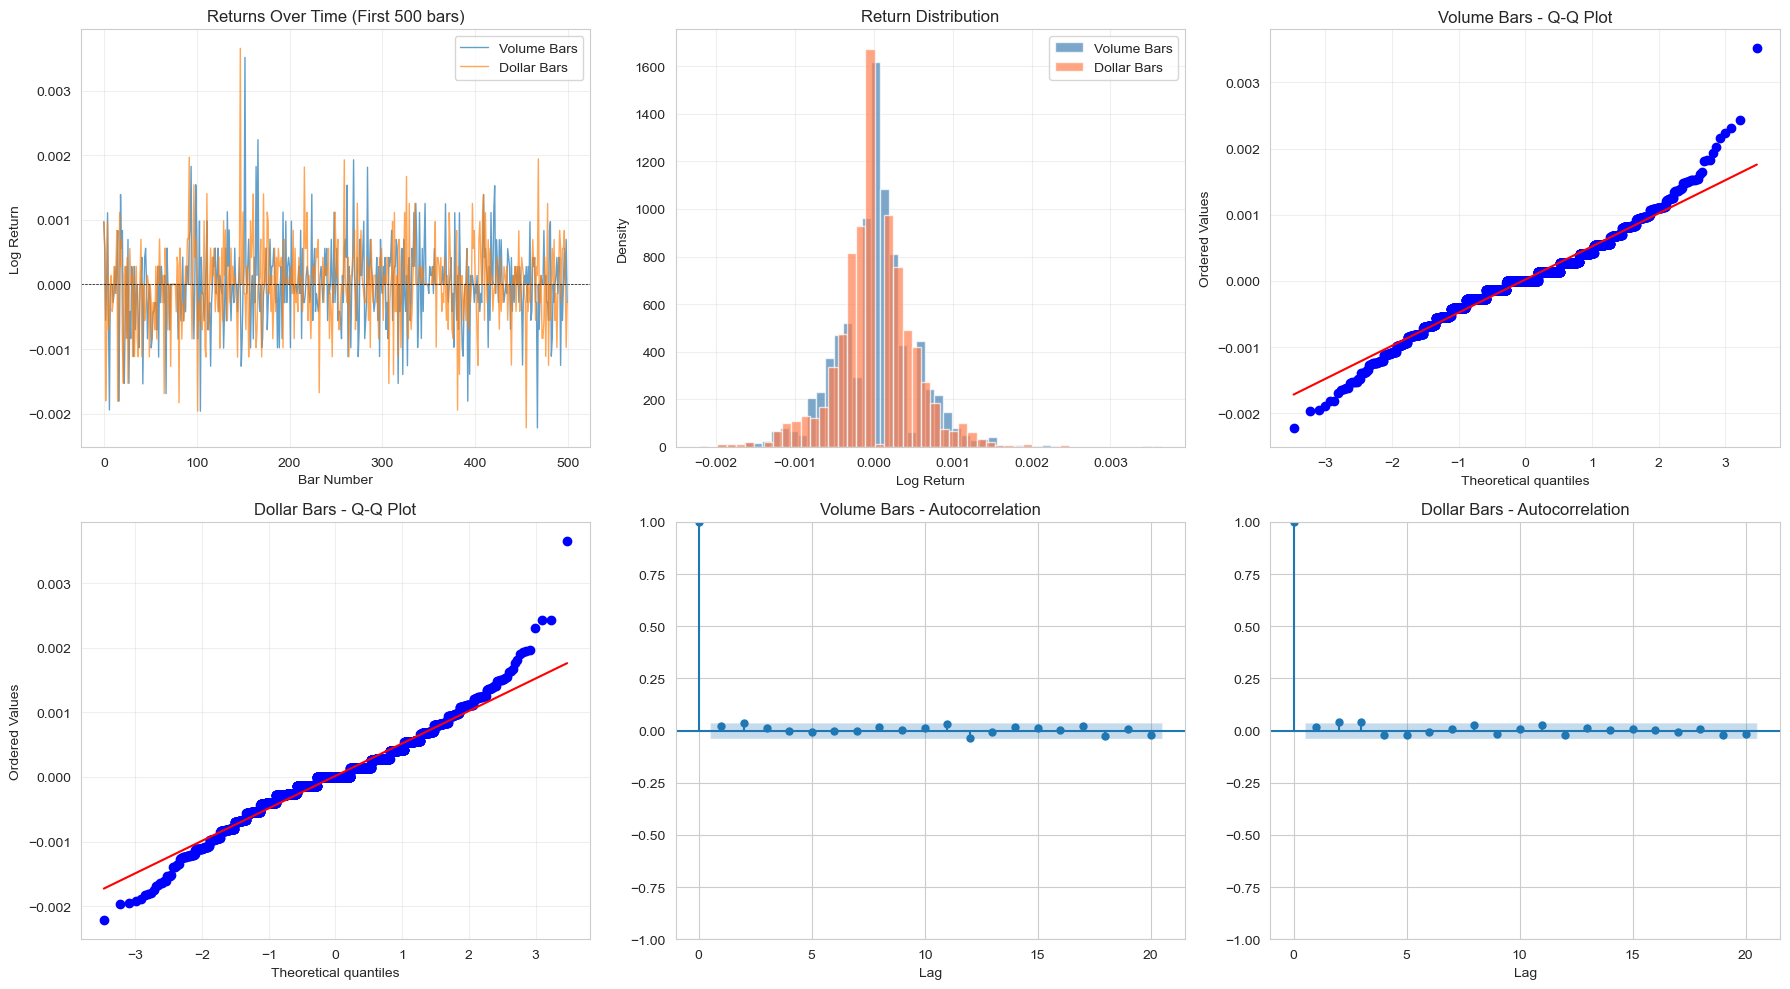

In [13]:
from statsmodels.stats.diagnostic import acorr_ljungbox

# Return statistics
print("="*80)
print("RETURN STATISTICS")
print("="*80)

print("\nVolume Bars:")
print(f"  Mean:     {vol_bars['return'].mean():.6f}")
print(f"  Std:      {vol_bars['return'].std():.6f}")
print(f"  Skewness: {stats.skew(vol_bars['return']):.4f}")
print(f"  Kurtosis: {stats.kurtosis(vol_bars['return']):.4f}")

print("\nDollar Bars:")
print(f"  Mean:     {dollar_bars['return'].mean():.6f}")
print(f"  Std:      {dollar_bars['return'].std():.6f}")
print(f"  Skewness: {stats.skew(dollar_bars['return']):.4f}")
print(f"  Kurtosis: {stats.kurtosis(dollar_bars['return']):.4f}")

# Autocorrelation
print("\n" + "="*80)
print("AUTOCORRELATION (Lag 1)")
print("="*80)
vol_acf1 = np.corrcoef(vol_bars['return'].iloc[:-1], vol_bars['return'].iloc[1:])[0, 1]
dollar_acf1 = np.corrcoef(dollar_bars['return'].iloc[:-1], dollar_bars['return'].iloc[1:])[0, 1]

print(f"Volume Bars: {vol_acf1:.6f}")
print(f"Dollar Bars: {dollar_acf1:.6f}")
print(f"Winner (closer to 0): {'DOLLAR' if abs(dollar_acf1) < abs(vol_acf1) else 'VOLUME'} bars")

# Ljung-Box test (test for autocorrelation)
print("\n" + "="*80)
print("LJUNG-BOX TEST (H0: No autocorrelation)")
print("="*80)

vol_lb = acorr_ljungbox(vol_bars['return'], lags=[10], return_df=True)
dollar_lb = acorr_ljungbox(dollar_bars['return'], lags=[10], return_df=True)

print("\nVolume Bars:")
print(f"  Test Statistic: {vol_lb['lb_stat'].iloc[0]:.4f}")
print(f"  P-value:        {vol_lb['lb_pvalue'].iloc[0]:.6f}")
print(f"  Result:         {'Reject H0 (autocorrelation present)' if vol_lb['lb_pvalue'].iloc[0] < 0.05 else 'Fail to reject H0 (no significant autocorrelation)'}")

print("\nDollar Bars:")
print(f"  Test Statistic: {dollar_lb['lb_stat'].iloc[0]:.4f}")
print(f"  P-value:        {dollar_lb['lb_pvalue'].iloc[0]:.6f}")
print(f"  Result:         {'Reject H0 (autocorrelation present)' if dollar_lb['lb_pvalue'].iloc[0] < 0.05 else 'Fail to reject H0 (no significant autocorrelation)'}")

print(f"\nWinner (higher p-value = less autocorrelation): {'DOLLAR' if dollar_lb['lb_pvalue'].iloc[0] > vol_lb['lb_pvalue'].iloc[0] else 'VOLUME'} bars")

# Plot returns
fig, axes = plt.subplots(2, 3, figsize=(18, 10))

# Return time series
ax = axes[0, 0]
ax.plot(vol_bars.index[:500], vol_bars['return'].iloc[:500], alpha=0.7, linewidth=1, label='Volume Bars')
ax.plot(dollar_bars.index[:500], dollar_bars['return'].iloc[:500], alpha=0.7, linewidth=1, label='Dollar Bars')
ax.set_xlabel('Bar Number')
ax.set_ylabel('Log Return')
ax.set_title('Returns Over Time (First 500 bars)')
ax.legend()
ax.grid(alpha=0.3)
ax.axhline(y=0, color='black', linestyle='--', linewidth=0.5)

# Return distributions
ax = axes[0, 1]
ax.hist(vol_bars['return'], bins=50, alpha=0.7, label='Volume Bars', color='steelblue', density=True)
ax.hist(dollar_bars['return'], bins=50, alpha=0.7, label='Dollar Bars', color='coral', density=True)
ax.set_xlabel('Log Return')
ax.set_ylabel('Density')
ax.set_title('Return Distribution')
ax.legend()
ax.grid(alpha=0.3)

# Q-Q plots
ax = axes[0, 2]
stats.probplot(vol_bars['return'], dist="norm", plot=ax)
ax.set_title('Volume Bars - Q-Q Plot')
ax.grid(alpha=0.3)

ax = axes[1, 0]
stats.probplot(dollar_bars['return'], dist="norm", plot=ax)
ax.set_title('Dollar Bars - Q-Q Plot')
ax.grid(alpha=0.3)

# ACF plots
from statsmodels.graphics.tsaplots import plot_acf

ax = axes[1, 1]
plot_acf(vol_bars['return'], lags=20, ax=ax, alpha=0.05)
ax.set_title('Volume Bars - Autocorrelation')
ax.set_xlabel('Lag')

ax = axes[1, 2]
plot_acf(dollar_bars['return'], lags=20, ax=ax, alpha=0.05)
ax.set_title('Dollar Bars - Autocorrelation')
ax.set_xlabel('Lag')

plt.tight_layout()
plt.show()


## 9. Comprehensive Comparison Across All Samples

Test bar properties across all ticker-date combinations.


In [14]:
# Create bars for all datasets and compare
bar_comparison = []

for ticker in data_dict:
    for date in data_dict[ticker]:
        df = data_dict[ticker][date]
        
        # Create both types of bars
        vol_bars_temp, _ = create_bars(df, bar_type='volume', target_bars_per_day=3000)
        dollar_bars_temp, _ = create_bars(df, bar_type='dollar', target_bars_per_day=3000)
        
        # Compute metrics
        comparison = {
            'ticker': ticker,
            'date': date,
            'total_trades': len(df),
            
            # Volume bar metrics
            'vol_num_bars': len(vol_bars_temp),
            'vol_duration_mean': vol_bars_temp['duration'].mean(),
            'vol_duration_cv': vol_bars_temp['duration'].std() / vol_bars_temp['duration'].mean(),
            'vol_return_std': vol_bars_temp['return'].std(),
            'vol_return_acf1': np.corrcoef(vol_bars_temp['return'].iloc[:-1], vol_bars_temp['return'].iloc[1:])[0, 1] if len(vol_bars_temp) > 1 else np.nan,
            'vol_return_skew': stats.skew(vol_bars_temp['return']),
            'vol_return_kurtosis': stats.kurtosis(vol_bars_temp['return']),
            
            # Dollar bar metrics
            'dollar_num_bars': len(dollar_bars_temp),
            'dollar_duration_mean': dollar_bars_temp['duration'].mean(),
            'dollar_duration_cv': dollar_bars_temp['duration'].std() / dollar_bars_temp['duration'].mean(),
            'dollar_return_std': dollar_bars_temp['return'].std(),
            'dollar_return_acf1': np.corrcoef(dollar_bars_temp['return'].iloc[:-1], dollar_bars_temp['return'].iloc[1:])[0, 1] if len(dollar_bars_temp) > 1 else np.nan,
            'dollar_return_skew': stats.skew(dollar_bars_temp['return']),
            'dollar_return_kurtosis': stats.kurtosis(dollar_bars_temp['return']),
        }
        
        # Ljung-Box p-values
        if len(vol_bars_temp) > 10:
            vol_lb_temp = acorr_ljungbox(vol_bars_temp['return'], lags=[10], return_df=True)
            comparison['vol_ljungbox_pvalue'] = vol_lb_temp['lb_pvalue'].iloc[0]
        else:
            comparison['vol_ljungbox_pvalue'] = np.nan
            
        if len(dollar_bars_temp) > 10:
            dollar_lb_temp = acorr_ljungbox(dollar_bars_temp['return'], lags=[10], return_df=True)
            comparison['dollar_ljungbox_pvalue'] = dollar_lb_temp['lb_pvalue'].iloc[0]
        else:
            comparison['dollar_ljungbox_pvalue'] = np.nan
        
        bar_comparison.append(comparison)

bar_comp_df = pd.DataFrame(bar_comparison)
print("Bar comparison completed!")
print(f"\nShape: {bar_comp_df.shape}")
bar_comp_df


Bar comparison completed!

Shape: (6, 19)


,ticker,date,total_trades,vol_num_bars,vol_duration_mean,vol_duration_cv,vol_return_std,vol_return_acf1,vol_return_skew,vol_return_kurtosis,dollar_num_bars,dollar_duration_mean,dollar_duration_cv,dollar_return_std,dollar_return_acf1,dollar_return_skew,dollar_return_kurtosis,vol_ljungbox_pvalue,dollar_ljungbox_pvalue
0,INTC,10-2-25,56511,2698,7.679763,1.082137,0.000508,0.021621,0.189526,2.433078,2700,7.664815,1.084016,0.000511,0.018348,0.160367,2.632119,7.947332e-01,1.143975e-01
1,INTC,10-3-25,43633,2581,7.991476,1.204507,0.000490,0.024631,0.093810,2.202029,2580,8.017442,1.210201,0.000489,0.014486,0.066117,1.924285,1.444129e-01,7.762315e-01
2,SMCI,10-2-25,19518,2410,7.848133,1.169936,0.000525,0.026929,0.133892,2.115644,2412,7.836650,1.167685,0.000523,0.044848,0.137202,2.199475,3.904806e-01,1.635592e-01
3,SMCI,10-3-25,19283,2344,8.150597,1.120824,0.000583,0.014980,-0.080662,2.427476,2341,8.160188,1.114737,0.000584,0.019326,-0.059985,2.567524,1.828189e-01,2.324086e-01
4,FCX,10-2-25,18967,2443,7.866558,1.199904,0.000942,-0.078168,-2.146210,666.827412,2442,7.841523,1.197793,0.000943,-0.078016,-2.142867,665.604668,1.114102e-56,2.318776e-56
5,FCX,10-3-25,15634,2426,7.584501,1.267090,0.000369,-0.003326,0.136082,2.548640,2432,7.537418,1.270617,0.000365,-0.019722,0.071526,2.491027,6.354918e-01,7.335727e-01


## 10. Final Recommendation


FINAL COMPARISON - AGGREGATE METRICS

METRIC COMPARISON:
--------------------------------------------------------------------------------

Per-second CV (lower = better):
  Volume: 4.223808
  Dollar: 4.222414
  Winner: DOLLAR

Per-second Fano Factor (lower = better):
  Volume: 5074.547045
  Dollar: 202166.592361
  Winner: VOLUME

Zero-activity % (lower = better):
  Volume: 67.976486
  Dollar: 67.976486
  Winner: VOLUME

Duration CV (lower = better):
  Volume: 1.174066
  Dollar: 1.174175
  Winner: VOLUME

Return ACF Lag-1 (closer to 0 = better):
  Volume: 0.001111
  Dollar: 0.000122
  Winner: DOLLAR

Ljung-Box p-value (higher = better):
  Volume: 0.357990
  Dollar: 0.336695
  Winner: VOLUME

Return Kurtosis (closer to 0 = better):
  Volume: 113.092380
  Dollar: 112.903183
  Winner: DOLLAR

FINAL SCORE
Volume Bars: 4 wins
Dollar Bars: 3 wins

RECOMMENDATION: Use VOLUME BARS


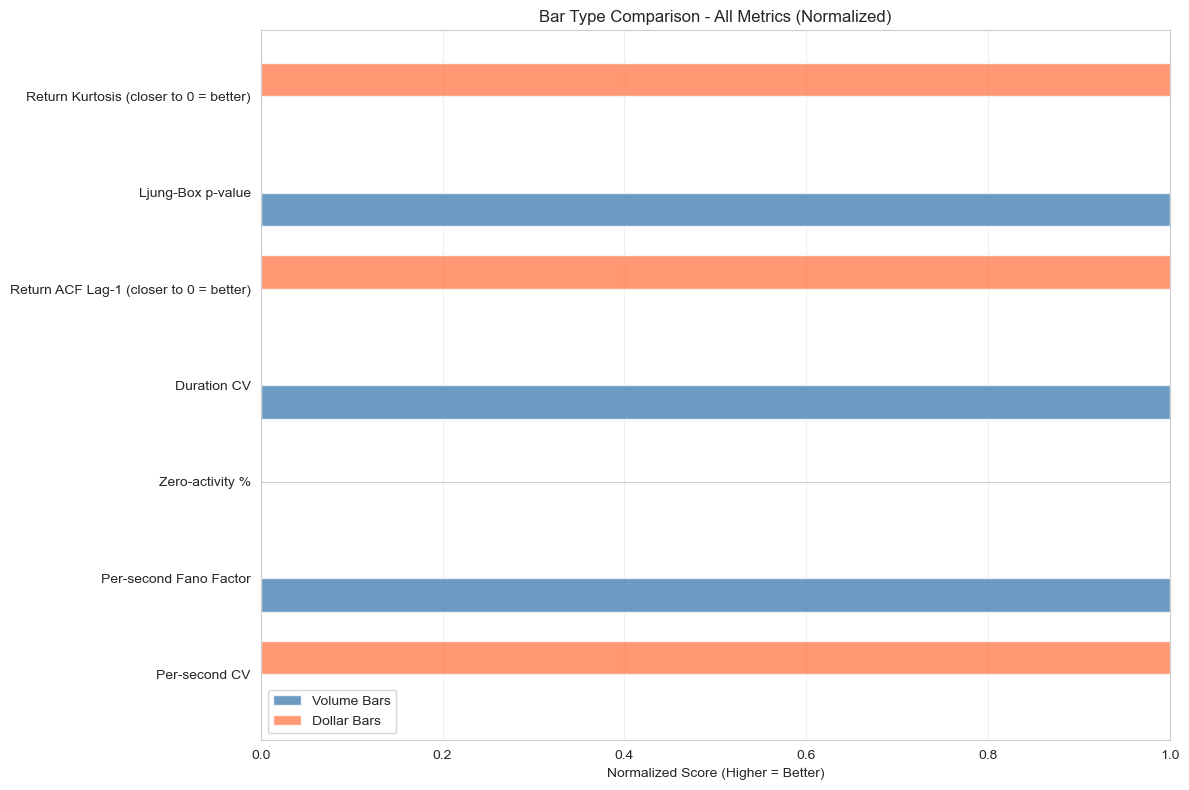

In [18]:
# Aggregate metrics
print("="*80)
print("FINAL COMPARISON - AGGREGATE METRICS")
print("="*80)

metrics = {
    'Duration CV (lower = better)': {
        'volume': bar_comp_df['vol_duration_cv'].mean(),
        'dollar': bar_comp_df['dollar_duration_cv'].mean(),
    },
    'Return ACF Lag-1 (closer to 0 = better)': {
        'volume': abs(bar_comp_df['vol_return_acf1'].mean()),
        'dollar': abs(bar_comp_df['dollar_return_acf1'].mean()),
    },
    'Ljung-Box p-value (higher = better)': {
        'volume': bar_comp_df['vol_ljungbox_pvalue'].mean(),
        'dollar': bar_comp_df['dollar_ljungbox_pvalue'].mean(),
    },
    'Return Kurtosis (closer to 0 = better)': {
        'volume': abs(bar_comp_df['vol_return_kurtosis'].mean()),
        'dollar': abs(bar_comp_df['dollar_return_kurtosis'].mean()),
    },
}

# Also include per-second flow metrics from earlier
per_sec_metrics = {
    'Per-second CV (lower = better)': {
        'volume': stats_df['volume_cv'].mean(),
        'dollar': stats_df['dollar_cv'].mean(),
    },
    'Per-second Fano Factor (lower = better)': {
        'volume': stats_df['volume_fano'].mean(),
        'dollar': stats_df['dollar_fano'].mean(),
    },
    'Zero-activity % (lower = better)': {
        'volume': stats_df['volume_zeros_pct'].mean(),
        'dollar': stats_df['dollar_zeros_pct'].mean(),
    },
}

# Combine all metrics
all_metrics = {**per_sec_metrics, **metrics}

# Determine winners
winners = {'volume': 0, 'dollar': 0}

print("\nMETRIC COMPARISON:")
print("-" * 80)
for metric_name, values in all_metrics.items():
    vol_val = values['volume']
    dollar_val = values['dollar']
    
    # Determine winner based on metric type
    if 'higher = better' in metric_name:
        winner = 'dollar' if dollar_val > vol_val else 'volume'
    else:  # lower is better
        winner = 'dollar' if dollar_val < vol_val else 'volume'
    
    winners[winner] += 1
    
    print(f"\n{metric_name}:")
    print(f"  Volume: {vol_val:.6f}")
    print(f"  Dollar: {dollar_val:.6f}")
    print(f"  Winner: {winner.upper()}")

print("\n" + "="*80)
print("FINAL SCORE")
print("="*80)
print(f"Volume Bars: {winners['volume']} wins")
print(f"Dollar Bars: {winners['dollar']} wins")
print("\n" + "="*80)
print(f"RECOMMENDATION: Use {'DOLLAR' if winners['dollar'] > winners['volume'] else 'VOLUME'} BARS")
print("="*80)

# Visualize final comparison
fig, ax = plt.subplots(figsize=(12, 8))

metric_names = list(all_metrics.keys())
vol_values = [all_metrics[m]['volume'] for m in metric_names]
dollar_values = [all_metrics[m]['dollar'] for m in metric_names]

# Normalize values for comparison (0-1 scale per metric)
vol_normalized = []
dollar_normalized = []
for i, metric in enumerate(metric_names):
    max_val = max(vol_values[i], dollar_values[i])
    min_val = min(vol_values[i], dollar_values[i])
    range_val = max_val - min_val if max_val != min_val else 1
    
    # For "higher is better" metrics, higher normalized value is better
    # For "lower is better" metrics, we invert so higher normalized value is still better
    if 'higher = better' in metric:
        vol_norm = (vol_values[i] - min_val) / range_val
        dollar_norm = (dollar_values[i] - min_val) / range_val
    else:
        vol_norm = (max_val - vol_values[i]) / range_val
        dollar_norm = (max_val - dollar_values[i]) / range_val
    
    vol_normalized.append(vol_norm)
    dollar_normalized.append(dollar_norm)

x = np.arange(len(metric_names))
width = 0.35

bars1 = ax.barh(x - width/2, vol_normalized, width, label='Volume Bars', alpha=0.8, color='steelblue')
bars2 = ax.barh(x + width/2, dollar_normalized, width, label='Dollar Bars', alpha=0.8, color='coral')

ax.set_xlabel('Normalized Score (Higher = Better)')
ax.set_title('Bar Type Comparison - All Metrics (Normalized)')
ax.set_yticks(x)
ax.set_yticklabels([m.replace(' (lower = better)', '').replace(' (higher = better)', '') for m in metric_names])
ax.legend()
ax.grid(axis='x', alpha=0.3)
ax.set_xlim(0, 1)

plt.tight_layout()
plt.show()
